<a href="https://colab.research.google.com/github/ArnaudOlt/dissertation_pybamm/blob/main/3_2_permanent_li_plt_loss_standard_lunana_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install pybtex
%pip install anytree
%pip install autograd
%pip install bpx
%pip install casadi
%pip install imageio
%pip install importlib-metadata
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-fem
%pip install scipy
%pip install sympy
%pip install tqdm
%pip install xarray
%pip install git+https://github.com/pybamm-team/pybamm.git@develop
import pybamm
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.3 MB/s eta 0:00:00
  Cloning https://github.com/pybamm-team/pybamm.git (to revision develop) to /tmp/pip-req-build-dlxfhxp2
  Running command git clone --filter=blob:none --quiet https://github.com/pybamm-team/pybamm.git /tmp/pip-req-build-dlxfhxp2
  Resolved https://github.com/pybamm-team/pybamm.git to commit efdb04ba7edf0fc8d01846d89777eb5a3b8f195e
  Preparing metadata (setup.py) ... done
  Created wheel for pybamm: filename=pybamm-23.5-py3-none-any.whl size=1103980 sha256=9208176f4ba69ace1ee5d7b9869dc51a47ccd52b3e0c29e0ab343b4bbf4cbadb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cxc4zfsh/wheels/86/5d/c0/01117b8a9a462c9838f1ca559e2d7b3b02536b4dd61d787fa3
Successfully built pybamm


In [3]:
model = pybamm.lithium_ion.SPMe(
    {
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
    }
)

In [4]:
prada2013_params = pybamm.ParameterValues("Prada2013")

def plating_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li plating reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter("Lithium plating kinetic rate constant [m.s-1]")

    return pybamm.constants.F * k_plating * c_e


def stripping_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li stripping reaction [A.m-2].

    References
    ----------

    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.

    Parameters
    ----------

    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]

    Returns
    -------

    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter("Lithium plating kinetic rate constant [m.s-1]")

    return pybamm.constants.F * k_plating * c_Li

def SEI_limited_dead_lithium_OKane2022(L_sei):
    """
    Decay rate for dead lithium formation [s-1].
    References
    ----------
    .. [1] Simon E. J. O'Kane, Weilong Ai, Ganesh Madabattula, Diega Alonso-Alvarez,
    Robert Timms, Valentin Sulzer, Jaqueline Sophie Edge, Billy Wu, Gregory J. Offer
    and Monica Marinescu. "Lithium-ion battery degradation: how to model it."
    Physical Chemistry: Chemical Physics 24, no. 13 (2022): 7909-7922.
    Parameters
    ----------
    L_sei : :class:`pybamm.Symbol`
        Total SEI thickness [m]
    Returns
    -------
    :class:`pybamm.Symbol`
        Dead lithium decay rate [s-1]
    """

    gamma_0 = pybamm.Parameter("Dead lithium decay constant [s-1]")
    L_inner_0 = pybamm.Parameter("Initial inner SEI thickness [m]")
    L_outer_0 = pybamm.Parameter("Initial outer SEI thickness [m]")
    L_sei_0 = L_inner_0 + L_outer_0

    gamma = gamma_0 * L_sei_0 / L_sei

    return gamma



prada2013_params.update({
        #experiment
        "Lower voltage cut-off [V]": 2.5,
        "Upper voltage cut-off [V]": 3.65,
        #cell
        "Negative current collector thickness [m]": 0.000006,
        "Separator thickness [m]": 0.000016,
        "Positive current collector thickness [m]": 0.000013,
        "Electrode height [m]": 0.325,
        "Electrode width [m]": 21.6,
        "Cell cooling surface area [m2]": 0.07338004,
        "Cell volume [m3]": 0.00106398976,
        "Positive current collector density [kg.m-3]": 2700,
        "Positive current collector thermal conductivity [W.m-1.K-1]": 237,
        "Nominal cell capacity [A.h]":100,
        "Current function [A]":100,
        "Contact resistance [Ohm]": 0.0004,
        #electrolyte
        "Electrolyte conductivity [S.m-1]": 0.97,



        #Okane2022 Li plating
        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-05,
        "Lithium plating kinetic rate constant [m.s-1]": 1e-09,
        "Exchange-current density for plating [A.m-2]": plating_exchange_current_density_OKane2020,
        "Exchange-current density for stripping [A.m-2]": stripping_exchange_current_density_OKane2020,
        "Initial plated lithium concentration [mol.m-3]": 0.0,
        "Typical plated lithium concentration [mol.m-3]": 1000.0,
        "Lithium plating transfer coefficient": 0.65,
        "Dead lithium decay constant [s-1]": 1e-06,
        "Dead lithium decay rate [s-1]": SEI_limited_dead_lithium_OKane2022,
        #Okane2022 SEI
        "Ratio of lithium moles to SEI moles": 1.0,
        "Inner SEI reaction proportion": 0.0,
        "Inner SEI partial molar volume [m3.mol-1]": 9.585e-05,
        "Outer SEI partial molar volume [m3.mol-1]": 9.585e-05,
        "SEI reaction exchange current density [A.m-2]": 1.5e-07,
        "SEI resistivity [Ohm.m]": 200000.0,
        "Outer SEI solvent diffusivity [m2.s-1]": 2.5000000000000002e-22,
        "Bulk solvent concentration [mol.m-3]": 2636.0,
        "Inner SEI open-circuit potential [V]": 0.1,
        "Outer SEI open-circuit potential [V]": 0.8,
        "Inner SEI electron conductivity [S.m-1]": 8.95e-14,
        "Inner SEI lithium interstitial diffusivity [m2.s-1]": 1e-20,
        "Lithium interstitial reference concentration [mol.m-3]": 15.0,
        "Initial inner SEI thickness [m]": 0.0,
        "Initial outer SEI thickness [m]": 5e-09,
        "EC initial concentration in electrolyte [mol.m-3]": 4541.0,
        "EC diffusivity [m2.s-1]": 2e-18,
        "SEI kinetic rate constant [m.s-1]": 1e-12,
        "SEI open-circuit potential [V]": 0.4,
        "SEI growth activation energy [J.mol-1]": 38000.0,
        "Negative electrode reaction-driven LAM factor [m3.mol-1]": 0.0,
        "Positive electrode reaction-driven LAM factor [m3.mol-1]": 0.0

        }, check_already_exists=False)


In [5]:
pybamm.set_logging_level("NOTICE")
cycle_number = 500
exp = pybamm.Experiment(
    [("Discharge at 1C until 2.5 V",  # ageing cycles
    "Charge at 0.3C until 3.65 V",
    "Hold at 3.65 V until C/20",
    "Rest for 4 hours",)] * cycle_number
)

In [6]:
temperatures = [268.15, 278.15,  288.15] #-5, 5, 15°C

solutions_standard = {} # dict, key is temp and values is solution object

for temp in temperatures:
    param = prada2013_params
    param.update({"Ambient temperature [K]": temp})

    sim = pybamm.Simulation(model, parameter_values=param, experiment=exp)
    safe_solver = pybamm.CasadiSolver(mode="safe", dt_max=120)
    sol = sim.solve(solver=safe_solver, calc_esoh=False)
    solutions_standard[temp] = sol
    solutions_standard[temp].save(f"solutions_standard_cycle_{temp}.pkl")


Streaming output truncated to the last 5000 lines.
2023-09-11 17:42:51.878 - [NOTICE] callbacks.on_step_start(180): Cycle 132/500, step 1/4: Discharge at 1C until 2.5 V
NOTICE:pybamm.logger:Cycle 132/500, step 1/4: Discharge at 1C until 2.5 V
At t = 505.35 repeated recoverable right-hand side function errors.
2023-09-11 17:42:52.029 - [NOTICE] callbacks.on_step_start(180): Cycle 132/500, step 2/4: Charge at 0.3C until 3.65 V
NOTICE:pybamm.logger:Cycle 132/500, step 2/4: Charge at 0.3C until 3.65 V
2023-09-11 17:42:52.219 - [NOTICE] callbacks.on_step_start(180): Cycle 132/500, step 3/4: Hold at 3.65 V until C/20
NOTICE:pybamm.logger:Cycle 132/500, step 3/4: Hold at 3.65 V until C/20
2023-09-11 17:42:52.413 - [NOTICE] callbacks.on_step_start(180): Cycle 132/500, step 4/4: Rest for 4 hours
NOTICE:pybamm.logger:Cycle 132/500, step 4/4: Rest for 4 hours
2023-09-11 17:42:52.763 - [NOTICE] callbacks.on_cycle_start(172): Cycle 133/500 (2 minutes, 18 seconds elapsed) --------------------
NOTICE

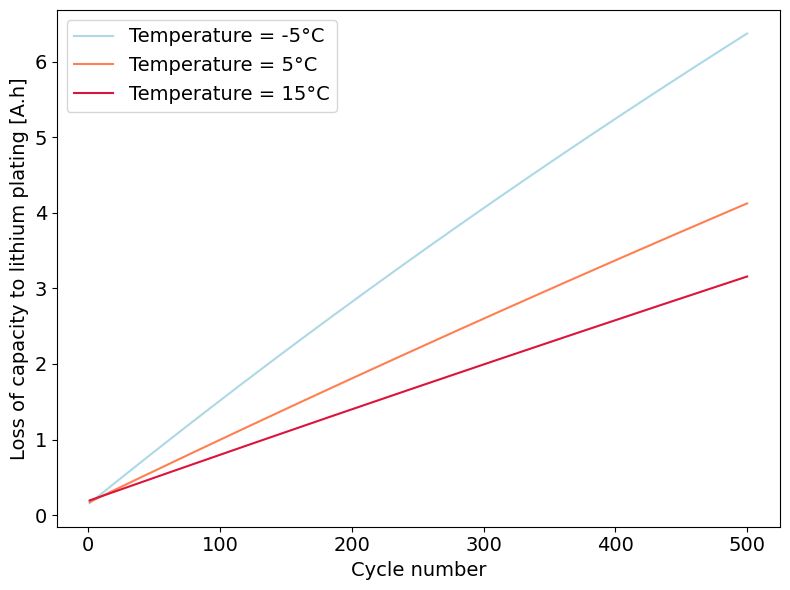

In [7]:
# plot loss of capacity to lithium plating at three temperatures

x_axis_var_str = "Cycle number"
y_axis_var_str = "Loss of capacity to lithium plating [A.h]"

fig, ax = plt.subplots(figsize=(8, 6))

line_colors = ["lightblue", "coral", "crimson"]
label_names = ["Temperature = -5°C", "Temperature = 5°C", "Temperature = 15°C", "Temperature = 14.3 °C"]


for i, (temp, sol) in enumerate(list(solutions_standard.items())[:3]):
    x_sol = sol.summary_variables[x_axis_var_str]
    y_sol = sol.summary_variables[y_axis_var_str]

    color = line_colors[i % len(line_colors)]  # Cycle through colors if needed
    label = label_names[i % len(label_names)]  # Cycle through label_names if needed
    ax.plot(x_sol, y_sol, label=label, color = color)

ax.set_xlabel(x_axis_var_str, fontsize=14)
ax.set_ylabel("Loss of capacity to lithium plating [A.h]", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize = 14)

plt.tight_layout()
plt.show()

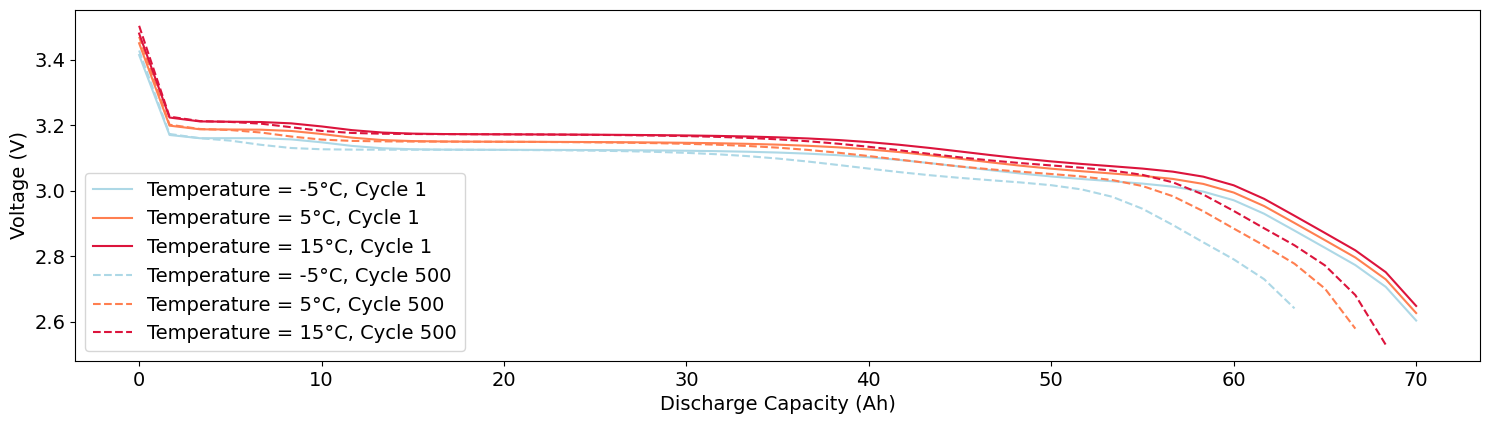

In [8]:
# plot discharge cycle at three temperatures

x_axis_var_str = "Discharge capacity [A.h]"
y_axis_var_str = "Battery voltage [V]"

first_cycle = 0
last_cycle = cycle_number - 1

# create figure
fig, ax = plt.subplots(figsize=(15, 8))

plt.subplots_adjust(left=-0.1)
discharge_curve = plt.subplot(211)

first_cycle_colors = ["lightblue", "coral", "crimson"]  # Choose colors for first cycles
last_cycle_colors = ["lightblue", "coral", "crimson"]  # Choose colors for last cycles

label_names_first = ["Temperature = -5°C, Cycle 1", "Temperature = 5°C, Cycle 1", "Temperature = 15°C, Cycle 1", "Temp = 14.3°C, Cycle 1"]
label_names_last = ["Temperature = -5°C, Cycle 500", "Temperature = 5°C, Cycle 500", "Temperature = 15°C, Cycle 500", "Temp = 14.3 °C, Cycle 500"]

for i, (temp, sol) in enumerate(list(solutions_standard.items())[:3]):
    for j, cycle in enumerate([first_cycle, last_cycle]):

        cut = np.argmin(sol.cycles[cycle][y_axis_var_str].data)

        discharge_capacity_sol = sol.cycles[cycle][x_axis_var_str].data[:cut]
        voltage_sol = sol.cycles[cycle][y_axis_var_str].data[:cut]

        if cycle == first_cycle:
            line_style = "-"
            label = label_names_first[i]
            color = first_cycle_colors[i]
        else:
            line_style = "--"
            label = label_names_last[i]
            color = last_cycle_colors[i]

        discharge_curve.plot(
            discharge_capacity_sol,
            voltage_sol,
            color=color,
            linestyle=line_style,
            label=label,
        )

discharge_curve.legend(loc="best")
plt.subplots_adjust(
    top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35
)


plt.xlabel(r"Discharge Capacity (Ah)", fontsize=14)
plt.ylabel("Voltage (V)", fontsize=14)
#plt.title(r"PyBaMM solution at different temperatures")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# reordering the labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order
order = [0,2,4, 1,3,5]

plt.legend(fontsize = 14)
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=14)


plt.tight_layout()

plt.show()


In [ ]:
# Run Lunana cycling protocol
pybamm.set_logging_level("NOTICE")
cycle_number = 500
exp_lunana = pybamm.Experiment(
    [("Discharge at 0.02C until 2.5 V",  # ageing cycles
    "Charge at 0.08C until 3.65 V",
    "Hold at 3.65 V until C/20",
    "Rest for 4 hours",)] * cycle_number
)

In [9]:
temperatures = [268.15, 278.15, 288.15] #-5, 5, 15°C

solutions_lunana = {} # dict, key is temp and values is solution object

for temp in temperatures:
    param = prada2013_params
    param.update({"Ambient temperature [K]": temp})

    sim = pybamm.Simulation(model, parameter_values=param, experiment=exp_lunana)
    safe_solver = pybamm.CasadiSolver(mode="safe", dt_max=120)
    sol = sim.solve(solver=safe_solver, calc_esoh=False)
    solutions_lunana[temp] = sol
    solutions_lunana[temp].save(f"solutions_lunana_cycle_{temp}.pkl")

Streaming output truncated to the last 5000 lines.
2023-09-11 03:28:58.457 - [NOTICE] callbacks.on_step_start(180): Cycle 1/500, step 1/4: Discharge at 0.02C until 2.5 V
NOTICE:pybamm.logger:Cycle 1/500, step 1/4: Discharge at 0.02C until 2.5 V
2023-09-11 03:29:01.475 - [NOTICE] callbacks.on_step_start(180): Cycle 1/500, step 2/4: Charge at 0.08C until 3.65 V
NOTICE:pybamm.logger:Cycle 1/500, step 2/4: Charge at 0.08C until 3.65 V
2023-09-11 03:29:02.264 - [NOTICE] callbacks.on_step_start(180): Cycle 1/500, step 3/4: Hold at 3.65 V until C/20
NOTICE:pybamm.logger:Cycle 1/500, step 3/4: Hold at 3.65 V until C/20
2023-09-11 03:29:02.713 - [NOTICE] callbacks.on_step_start(180): Cycle 1/500, step 4/4: Rest for 4 hours
NOTICE:pybamm.logger:Cycle 1/500, step 4/4: Rest for 4 hours
2023-09-11 03:29:03.593 - [NOTICE] callbacks.on_cycle_start(172): Cycle 2/500 (5.141 s elapsed) --------------------
NOTICE:pybamm.logger:Cycle 2/500 (5.141 s elapsed) --------------------
2023-09-11 03:29:03.599 - 

KeyboardInterrupt: ignored

In [ ]:
# Comparing different C rates over 500 cycles for Lunana and standard cycling protocol

x_axis_var_str = "Time [h]"
y_axis_var_str = "Loss of capacity to lithium plating [A.h]"


fig, ax = plt.subplots(figsize=(8, 6))

line_colors = ["lightblue", "coral", "crimson", "cyan", "magenta", "yellow"]
label_names_standard = ["Temperature = -5°C, standard cycling", "Temperature = 5°C, standard cycling", "Temperature = 15°C, standard cycling", "Temperature = 14.3 °C"]
label_names_lunana = ["Temperature = -5°C, adjusted cycling", "Temperature = 5°C, adjusted cycling", "Temperature = 15°C, adjusted cycling", "Temperature = 14.3 °C"]


for i, (temp, sol) in enumerate(list(solutions_standard.items())[:3]):
    x_sol = sol.summary_variables[x_axis_var_str]
    y_sol = sol.summary_variables[y_axis_var_str]

    color = line_colors[i % len(line_colors)]  # Cycle through colors if needed
    label = label_names_standard[i % len(label_names_standard)]  # Cycle through label_names if needed

    ax.plot(x_sol, y_sol, label=label, color = color)

for i, (temp, sol) in enumerate(list(solutions_lunana.items())[:3]):
    x_sol = sol.summary_variables[x_axis_var_str]
    y_sol = sol.summary_variables[y_axis_var_str]

    color = line_colors[i % len(line_colors)]  # Cycle through colors if needed
    label = label_names_lunana[i % len(label_names_lunana)]  # Cycle through label_names if needed
    ax.plot(x_sol, y_sol, label=label, color = color, linestyle="--")


ax.set_xlabel(x_axis_var_str, fontsize=14)
ax.set_ylabel("Loss of capacity to lithium plating [A.h]", fontsize=14)
#ax.set_title("Loss of Capacity to Lithium Plating")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize = 13)

plt.tight_layout()
plt.show()